# Poisson Regression Tutorial using `statsmodels`

This Notebook is another perspective to make Poisson Regression using `statsmodels`. 

## Libraries

In [56]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## References

This Notebook is based on the _Towards data science_ article: \\
* [An Illustrated Guide to the Poisson Regression Model](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958)

## Case Study

This Notebook will lean on a simple case study: The number of bicyclists traveling over various NYC bridges, from 01 April 2017 to 31 October 2017.

## Creating DataFrame from Dataset

### Loading data

In [57]:
df = pd.read_csv('https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv', infer_datetime_format=True, parse_dates=[0],index_col=[0])

In [58]:
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


#### Data Visualisation

In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(name='Bicyclists Number', x=df.index, y=df['BB_COUNT'], mode='lines', line=dict(width=3, color='red')))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Days',
    yaxis_title='Bicyclists Number',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text='Bicyclists on NYC bridges')

fig.show()

### Formatting the DataFrame

In [60]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [61]:
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


## Creating Training and Testing Datasets

Considering that the `statsmodels` library is based on Machine Learning, we need to first create a **Training Dataset** and a **Testing Dataset**.

In [62]:

# Defining a noise mask
mask = np.random.rand(len(df)) < 0.8

df_train = df[mask]
df_test = df[~mask]

print('Training data set length = '+str(len(df_train)))
print('Testing data set length = '+str(len(df_test)))

Training data set length = 180
Testing data set length = 34


## Defining the Regression Expression

Formatting in Patsy notation.

In [63]:
expr = """BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

## Poisson Regression training

Before using Machine Learning, X and y matrices for training and testing data sets need to be prepared.

In [64]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')

y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the `statsmodels` library to train the Poisson Regression model on the training data set.

In [65]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

## Training Summary

In [66]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  180
Model:                            GLM   Df Residuals:                      173
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12673.
Date:                Thu, 13 May 2021   Deviance:                       23611.
Time:                        16:23:31   Pearson chi2:                 2.37e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0633      0.012    572.086      

## Predictions on the Test Dataset

In [67]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2017-04-08,2310.440416,10.596370,2289.764977,2331.302545
2017-04-12,2852.390905,8.696580,2835.396748,2869.486918
2017-04-15,2366.155363,8.225811,2350.087871,2382.332707
2017-04-18,2755.713953,10.111870,2735.966150,2775.604294
2017-04-27,2375.311148,8.817932,2358.091042,2392.657005


## Visualisation

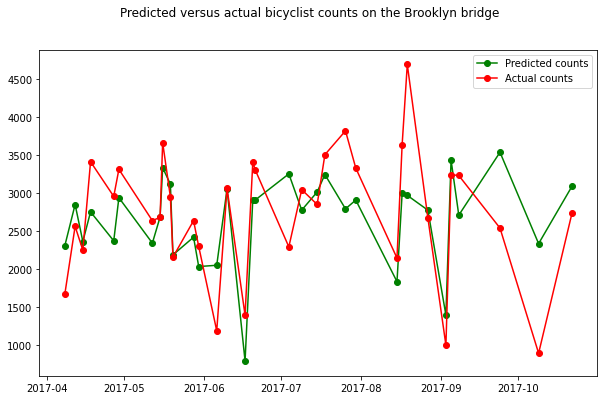

In [68]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure(figsize=[10,6])
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

## Precision

To see if our Machine Learning model is doing well, we can plot the linear regression of _Actual Counts_ versus the _Predicted Counts_. 

<Figure size 432x288 with 0 Axes>

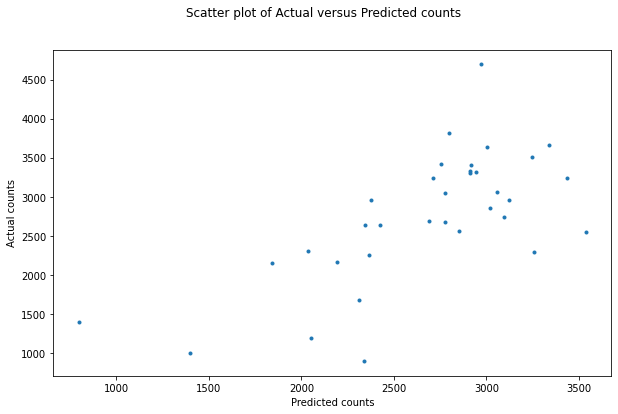

In [69]:
plt.clf()
fig = plt.figure(figsize=[10,6])
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

The expected result would be a x=y curve if the Predicted Data would be the same as the Actual Data. 

## Conclusion

>As a conclusion, through this Notebook we have learnt to implement a Poisson Regression using the `statsmodels` ML library. The predicted result is more or less accurate. 